In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Load BASELINE datasets
df_baseline_block_latency = pd.read_csv("baseline/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("baseline/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("baseline/write_bytes.csv")

# Load CPU STRESS datasets
df_cpustress_block_latency = pd.read_csv("cpu stress/block_count_latency_device.csv")
df_cpustress_read_bytes = pd.read_csv("cpu stress/read_bytes.csv")
df_cpustress_write_bytes = pd.read_csv("cpu stress/write_bytes.csv")

# Load IO datasets
df_IO_block_latency = pd.read_csv("IO pressure/block_count_latency_device.csv")
df_IO_read_bytes = pd.read_csv("IO pressure/read_bytes.csv")
df_IO_write_bytes = pd.read_csv("IO pressure/write_bytes.csv")

# Load MEM STRESS datasets
df_memstress_block_latency = pd.read_csv("mem stress/block_count_latency_device.csv")
df_memstress_read_bytes = pd.read_csv("mem stress/read_bytes.csv")
df_memstress_write_bytes = pd.read_csv("mem stress/write_bytes.csv")

# Load NET LOSS datasets
df_netloss_block_latency = pd.read_csv("net loss/block_count_latency_device.csv")
df_netloss_read_bytes = pd.read_csv("net loss/read_bytes.csv")
df_netloss_write_bytes = pd.read_csv("net loss/write_bytes.csv")


# Add source labels - BASELINE
df_baseline_block_latency["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Add source labels - CPU STRESS
df_cpustress_block_latency["source"] = "CPU_STRESS"
df_cpustress_read_bytes["source"] = "CPU_STRESS"
df_cpustress_write_bytes["source"] = "CPU_STRESS"

# Add source labels - DELAY
df_IO_block_latency["source"] = "DELAY"
df_IO_read_bytes["source"] = "DELAY"
df_IO_write_bytes["source"] = "DELAY"

# Add source labels - MEM STRESS
df_memstress_block_latency["source"] = "MEM_STRESS"
df_memstress_read_bytes["source"] = "MEM_STRESS"
df_memstress_write_bytes["source"] = "MEM_STRESS"

# Add source labels - NET LOSS
df_netloss_block_latency["source"] = "NET_LOSS"
df_netloss_read_bytes["source"] = "NET_LOSS"
df_netloss_write_bytes["source"] = "NET_LOSS"


# Convert to datetime - BASELINE
df_baseline_block_latency["Time"] = pd.to_datetime(df_baseline_block_latency["Time"])
df_baseline_read_bytes["Time"] = pd.to_datetime(df_baseline_read_bytes["Time"])
df_baseline_write_bytes["Time"] = pd.to_datetime(df_baseline_write_bytes["Time"])

# Convert to datetime - CPU STRESS
df_cpustress_block_latency["Time"] = pd.to_datetime(df_cpustress_block_latency["Time"])
df_cpustress_read_bytes["Time"] = pd.to_datetime(df_cpustress_read_bytes["Time"])
df_cpustress_write_bytes["Time"] = pd.to_datetime(df_cpustress_write_bytes["Time"])

# Convert to datetime - IO
df_IO_block_latency["Time"] = pd.to_datetime(df_IO_block_latency["Time"])
df_IO_read_bytes["Time"] = pd.to_datetime(df_IO_read_bytes["Time"])
df_IO_write_bytes["Time"] = pd.to_datetime(df_IO_write_bytes["Time"])

# Convert to datetime - MEM STRESS
df_memstress_block_latency["Time"] = pd.to_datetime(df_memstress_block_latency["Time"])
df_memstress_read_bytes["Time"] = pd.to_datetime(df_memstress_read_bytes["Time"])
df_memstress_write_bytes["Time"] = pd.to_datetime(df_memstress_write_bytes["Time"])

# Convert to datetime - NET LOSS
df_netloss_block_latency["Time"] = pd.to_datetime(df_netloss_block_latency["Time"])
df_netloss_read_bytes["Time"] = pd.to_datetime(df_netloss_read_bytes["Time"])
df_netloss_write_bytes["Time"] = pd.to_datetime(df_netloss_write_bytes["Time"])


delay = 30
duration = 50

# Synchronize all datasets with baseline timeline
time_offset = df_baseline_block_latency["Time"].min()

# Synchronize CPU STRESS datasets
cpustress_offset = time_offset - df_cpustress_block_latency["Time"].min()
df_cpustress_block_latency["Time"] += cpustress_offset
df_cpustress_read_bytes["Time"] += cpustress_offset
df_cpustress_write_bytes["Time"] += cpustress_offset

# Synchronize DELAY datasets
delay_offset = time_offset - df_IO_block_latency["Time"].min()
df_IO_block_latency["Time"] += delay_offset
df_IO_read_bytes["Time"] += delay_offset
df_IO_write_bytes["Time"] += delay_offset

# Synchronize MEM STRESS datasets
memstress_offset = time_offset - df_memstress_block_latency["Time"].min()
df_memstress_block_latency["Time"] += memstress_offset
df_memstress_read_bytes["Time"] += memstress_offset
df_memstress_write_bytes["Time"] += memstress_offset

# Synchronize NET LOSS datasets
netloss_offset = time_offset - df_netloss_block_latency["Time"].min()
df_netloss_block_latency["Time"] += netloss_offset
df_netloss_read_bytes["Time"] += netloss_offset
df_netloss_write_bytes["Time"] += netloss_offset


# Convert timeline to minutes for ALL datasets
all_dfs = [
    # Baseline
    df_baseline_block_latency, df_baseline_read_bytes, df_baseline_write_bytes,
    # CPU Stress
    df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes,
    # Delay
    df_IO_block_latency, df_IO_read_bytes, df_IO_write_bytes,
    # Memory Stress
    df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes,
    # Network Loss
    df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# COMPLETE DATASETS DICTIONARY 
all_datasets = {
    'BlockLatency': {
        'baseline': df_baseline_block_latency,
        'cpu_stress': df_cpustress_block_latency,
        'delay': df_IO_block_latency,
        'mem_stress': df_memstress_block_latency,
        'net_loss': df_netloss_block_latency,
    },
    'ReadBytes': {
        'baseline': df_baseline_read_bytes,
        'cpu_stress': df_cpustress_read_bytes,
        'delay': df_IO_read_bytes,
        'mem_stress': df_memstress_read_bytes,
        'net_loss': df_netloss_read_bytes,
    },
    'WriteBytes': {
        'baseline': df_baseline_write_bytes,
        'cpu_stress': df_cpustress_write_bytes,
        'delay': df_IO_write_bytes,
        'mem_stress': df_memstress_write_bytes,
        'net_loss': df_netloss_write_bytes,
    }
}

print("✅ All I/O datasets loaded successfully!")
print(f"📊 Loaded {len(all_datasets)} I/O metrics across {len(all_datasets['BlockLatency'])} experiment types")
print("\nDataset structure:")
for metric, experiments in all_datasets.items():
    print(f"  {metric}: {list(experiments.keys())}")

✅ All I/O datasets loaded successfully!
📊 Loaded 3 I/O metrics across 5 experiment types

Dataset structure:
  BlockLatency: ['baseline', 'cpu_stress', 'delay', 'mem_stress', 'net_loss']
  ReadBytes: ['baseline', 'cpu_stress', 'delay', 'mem_stress', 'net_loss']
  WriteBytes: ['baseline', 'cpu_stress', 'delay', 'mem_stress', 'net_loss']


Running TUNA analysis on disk I/O datasets...
Processing BlockLatency
Training BlockLatency...
  Skipped ML enhancement for BlockLatency - baseline (discrete data: 3 unique values)
  Skipped ML enhancement for BlockLatency - cpu_stress (discrete data: 2 unique values)
  Skipped ML enhancement for BlockLatency - delay (discrete data: 2 unique values)
  Skipped ML enhancement for BlockLatency - mem_stress (discrete data: 3 unique values)
  Skipped ML enhancement for BlockLatency - net_loss (discrete data: 2 unique values)
Processing ReadBytes
Training ReadBytes...
  Skipped ML enhancement for ReadBytes - baseline (discrete data: 1 unique values)
  Applied ML enhancement for ReadBytes - cpu_stress
  Applied ML enhancement for ReadBytes - delay
  Applied ML enhancement for ReadBytes - mem_stress
  Applied ML enhancement for ReadBytes - net_loss
Processing WriteBytes
Training WriteBytes...
  Applied ML enhancement for WriteBytes - baseline
  Applied ML enhancement for WriteBytes - cpu_stres

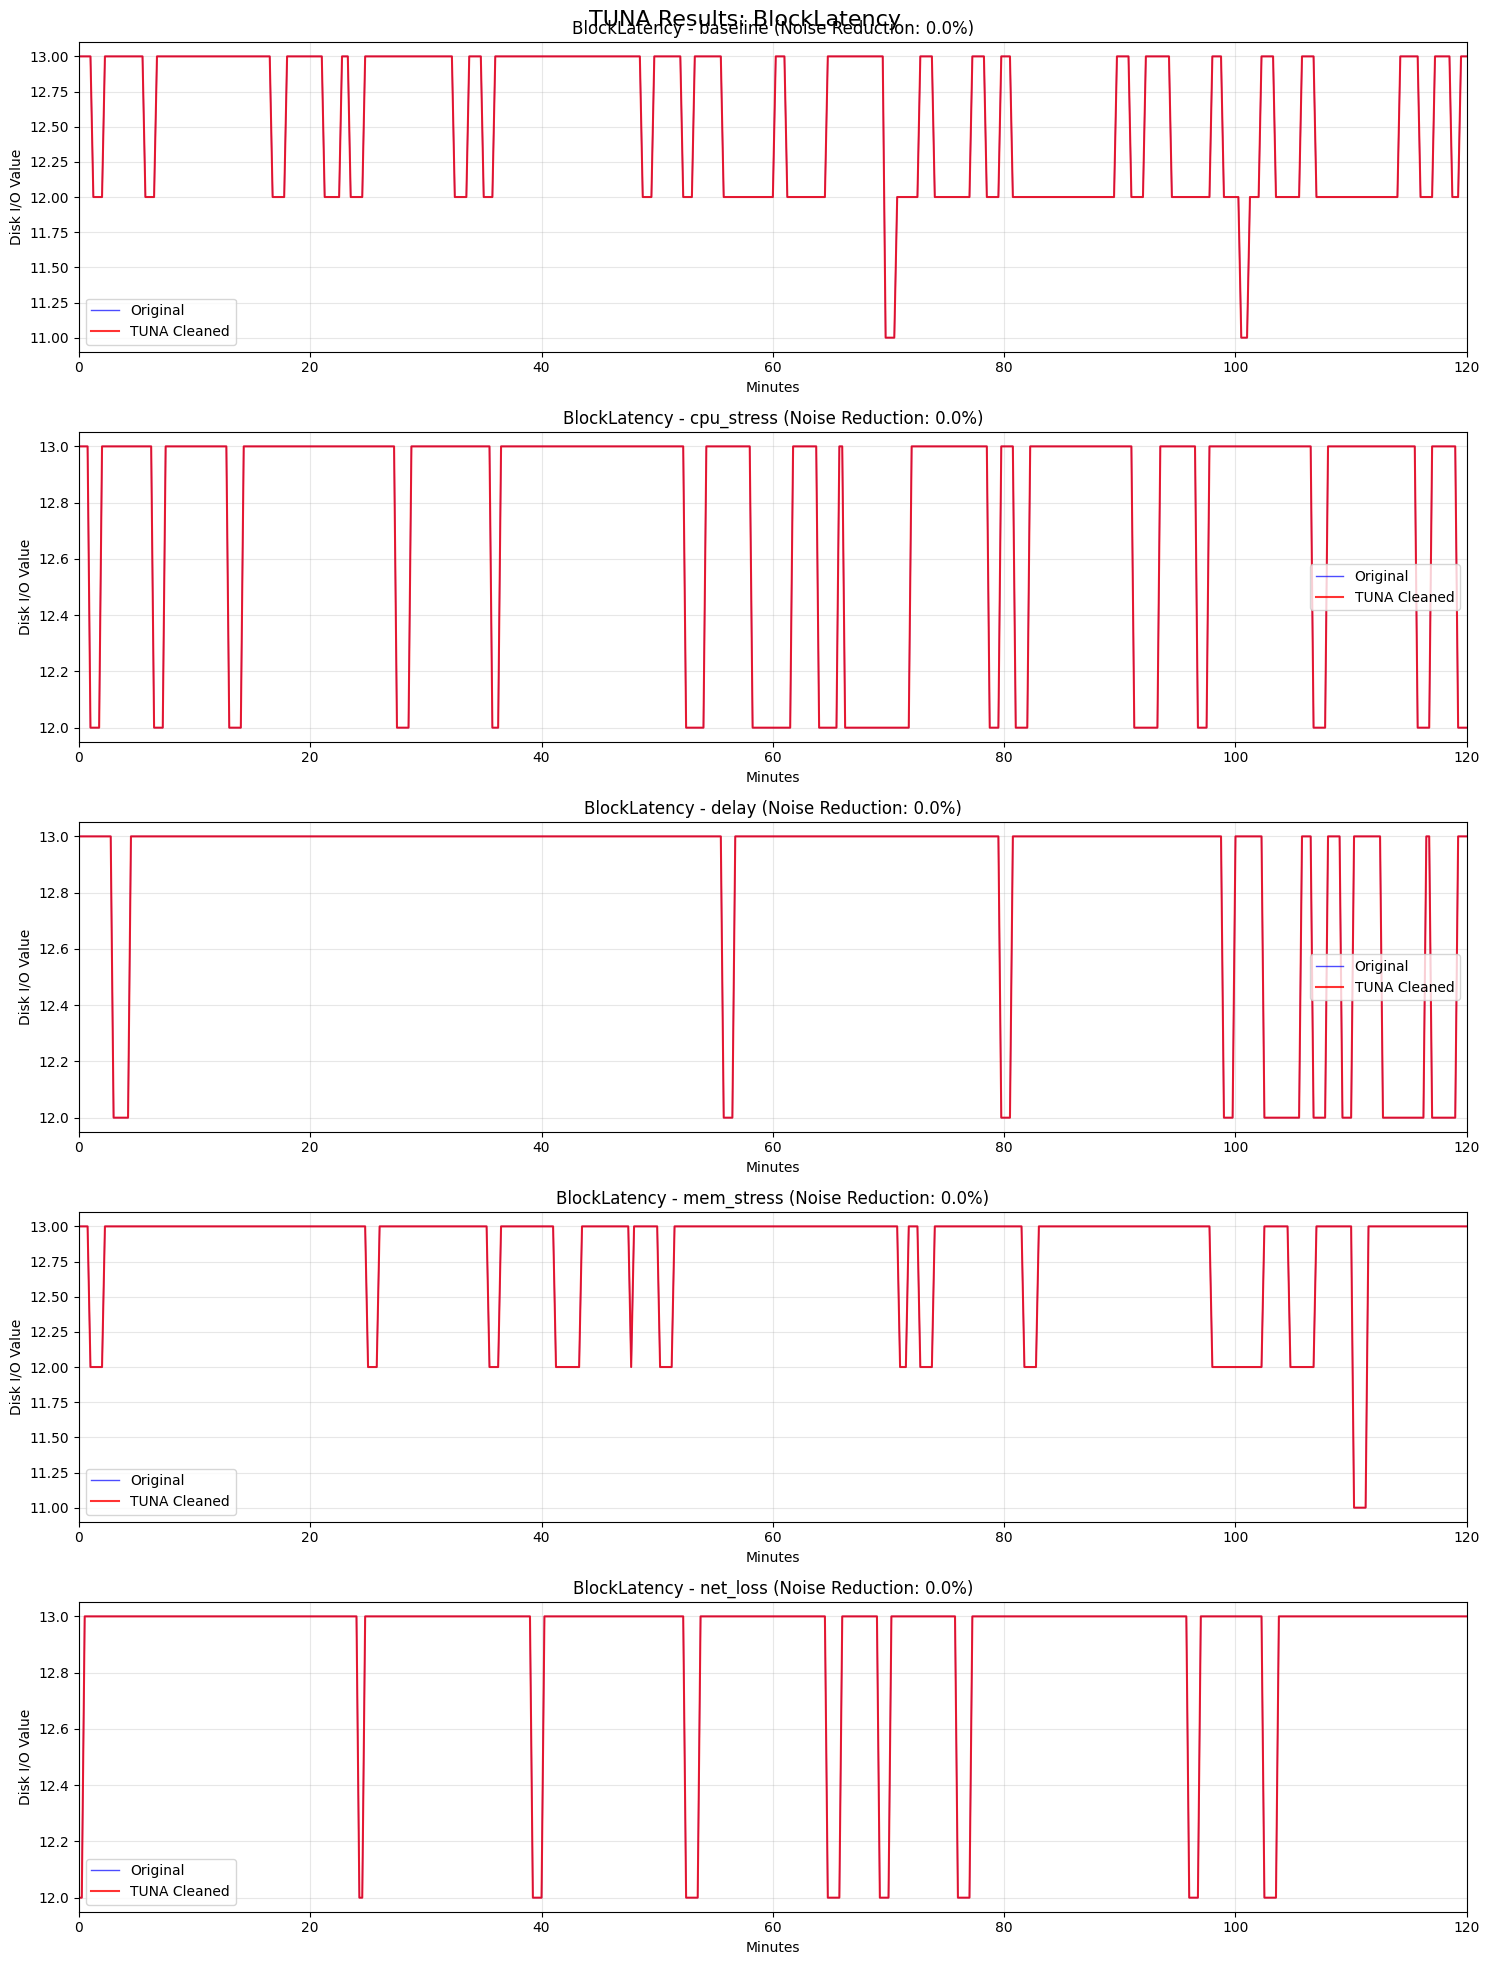

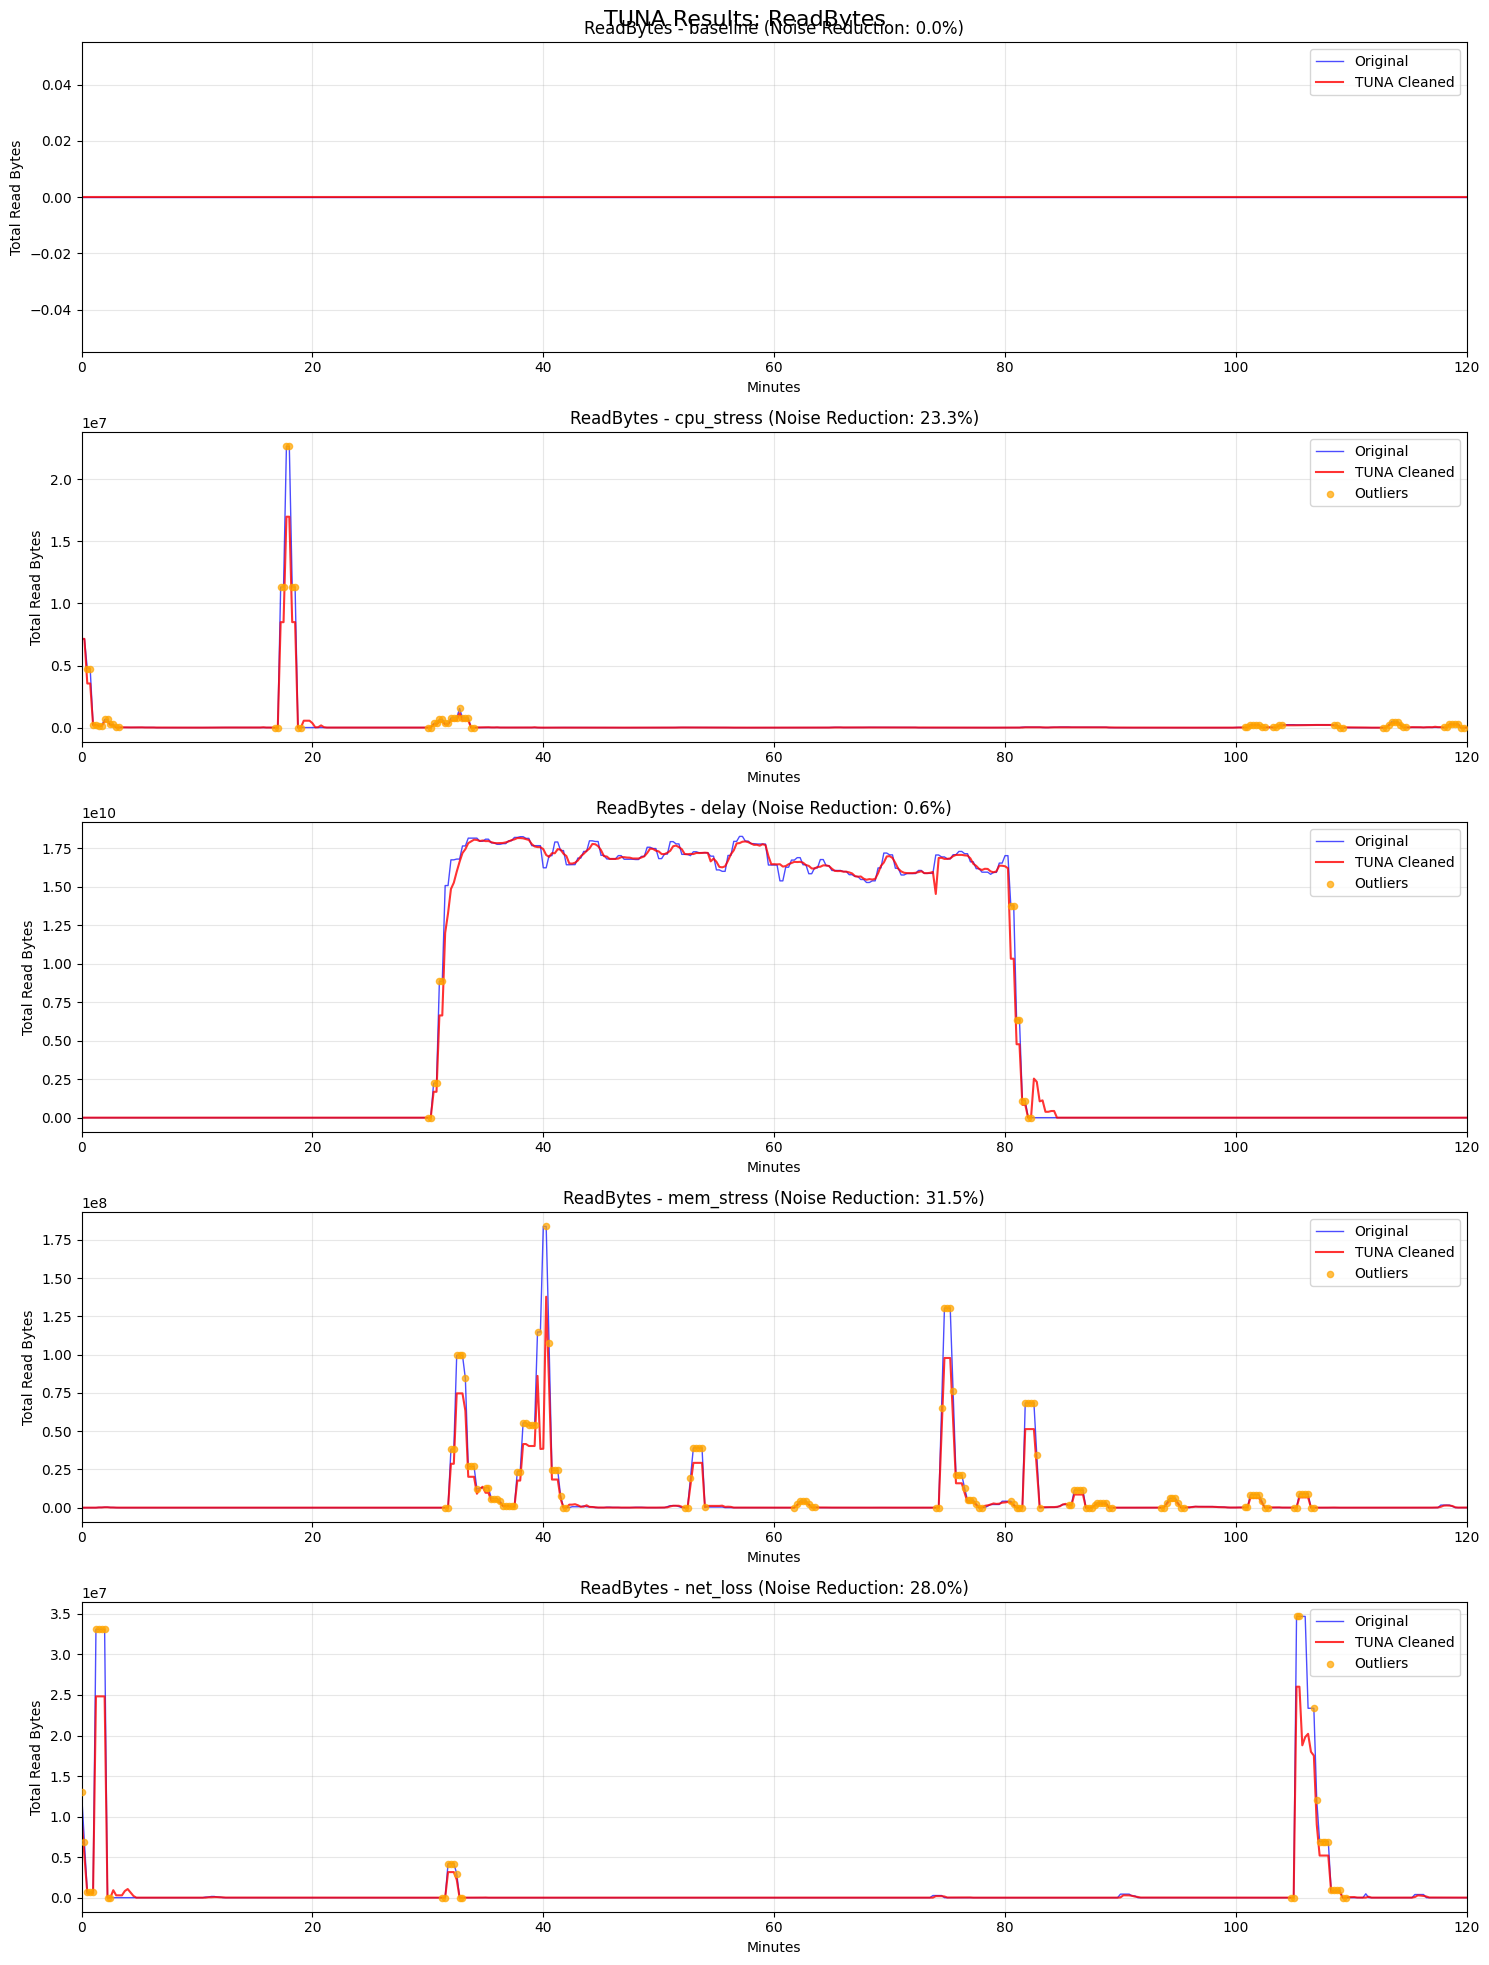

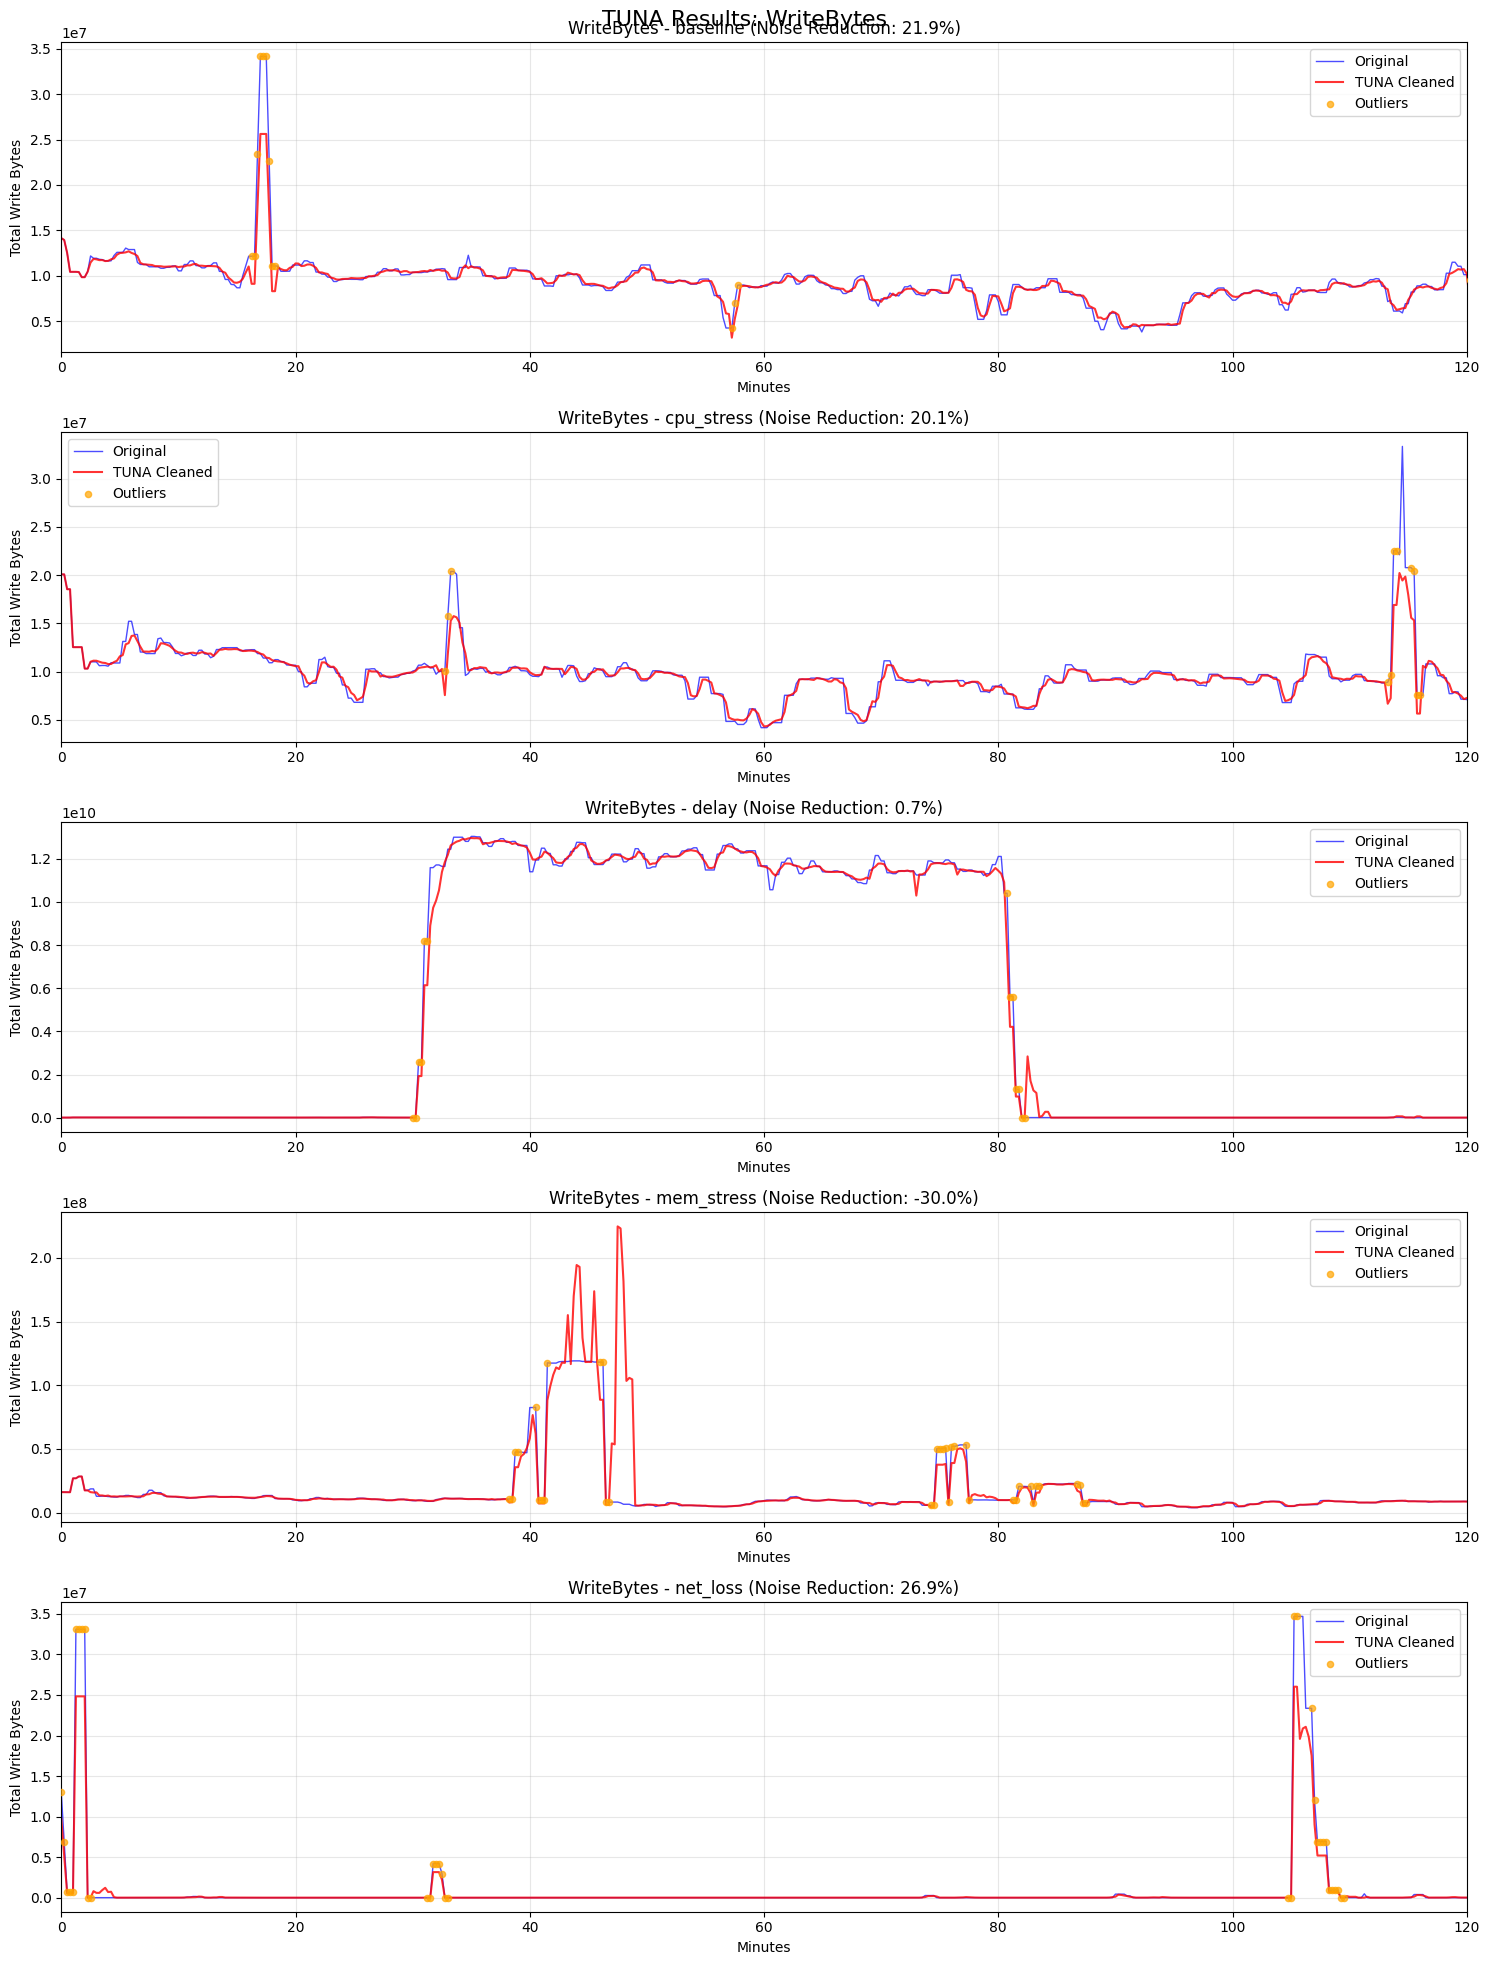


Disk I/O TUNA Results Summary:
Metric          Experiment   Outliers   Gap-Filled  Noise Red%   Correlation 
----------------------------------------------------------------------
BlockLatency    baseline     0          0                  0.0%       1.000
BlockLatency    cpu_stress   0          0                  0.0%       1.000
BlockLatency    delay        0          0                  0.0%       1.000
BlockLatency    mem_stress   0          0                  0.0%       1.000
BlockLatency    net_loss     0          0                  0.0%       1.000
ReadBytes       baseline     0          0                  0.0%         nan
ReadBytes       cpu_stress   72         1                 23.3%       0.996
ReadBytes       delay        14         0                  0.6%       0.999
ReadBytes       mem_stress   125        12                31.5%       0.954
ReadBytes       net_loss     35         3                 28.0%       0.992
WriteBytes      baseline     15         2                 2

In [2]:
def extract_disk_values(df, metric_name):
    """Extract disk values - single column for DiskUtil, sum for ReadBytes/WriteBytes"""
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'DiskUtil':
        # For disk utilization, we typically have a single disk column
        if len(value_cols) == 1:
            return df[value_cols[0]].values
        else:
            # If multiple disks, take the primary one or sum (depending on use case)
            return df[value_cols[0]].values  # Take first disk as primary
    else:
        # For ReadBytes/WriteBytes, sum across all partitions/devices
        return df[value_cols].sum(axis=1).values

def detect_outliers_tuna(timeseries, window_size=3, threshold=0.65, min_absolute_range=None):
    """
    TUNA's relative range outlier detection with stability improvements
    Formula: (max - min) / mean > threshold
    Mark only the max/min values in unstable windows as outliers
    """
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    
    # Calculate adaptive minimum absolute range if not provided
    if min_absolute_range is None:
        # Use 5% of the overall time series standard deviation as minimum range
        min_absolute_range = 0.1 * np.std(timeseries)
    
    # Slide window across time series to detect unstable periods
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0:
            # Apply TUNA relative range criterion
            relative_range = window_range / window_mean
            
            # Additional filter: require minimum absolute range to avoid hypersensitivity
            if relative_range > threshold and window_range > min_absolute_range:
                window_max = np.max(window)
                window_min = np.min(window)
                
                # Mark extreme values within unstable window
                for j in range(window_size):
                    actual_idx = i + j
                    if (timeseries[actual_idx] == window_max or 
                        timeseries[actual_idx] == window_min):
                        outlier_mask[actual_idx] = True
    
    return outlier_mask

def extend_outlier_sequences(outlier_mask, max_gap=2):
    """Fill short gaps between outliers to prevent W-shapes"""
    extended_mask = outlier_mask.copy()
    
    for i in range(len(outlier_mask) - max_gap - 1):
        if outlier_mask[i]:  # Found outlier
            # Look ahead for next outlier within max_gap
            for gap in range(1, max_gap + 1):
                if i + gap < len(outlier_mask) and outlier_mask[i + gap]:
                    # Fill the gap
                    extended_mask[i:i+gap+1] = True
                    break
    
    return extended_mask

def create_features_for_ml(timeseries, experiment_type, window_size=10):
    """Create features for RandomForest training"""
    features = []
    
    # Extract temporal and statistical features from sliding windows
    for i in range(window_size, len(timeseries)):
        window = timeseries[i-window_size:i]
        
        # Statistical features from recent history
        feature_vector = [
            np.mean(window),                    # Rolling average
            np.std(window),                     # Variability measure
            np.median(window),                  # Robust central tendency
            np.max(window) - np.min(window),    # Range indicator
            timeseries[i-1],                    # Previous value dependency
            i / len(timeseries),                # Temporal position
        ]
        
        # Experiment context encoding for cross-experiment learning
        exp_features = [0, 0, 0, 0, 0]
        if experiment_type == "baseline":
            exp_features[0] = 1
        elif experiment_type == "cpu_stress":
            exp_features[1] = 1
        elif experiment_type == "delay":
            exp_features[2] = 1
        elif experiment_type == "mem_stress":
            exp_features[3] = 1
        elif experiment_type == "net_loss":
            exp_features[4] = 1
        
        feature_vector.extend(exp_features)
        features.append(feature_vector)
    
    return np.array(features)

def train_random_forest_for_metric(metric_name, all_experiments):
    """Train RandomForest on stable periods across all experiments"""
    print(f"Training {metric_name}...")
    
    X_stable_all = []
    y_stable_all = []
    
    # Aggregate stable training data from all experimental conditions
    for exp_name, df in all_experiments.items():
        disk_values = extract_disk_values(df, metric_name)
        outlier_mask = detect_outliers_tuna(disk_values)
        stable_mask = ~outlier_mask
        
        features = create_features_for_ml(disk_values, exp_name)
        # Align feature window with stability detection
        stable_features_mask = stable_mask[10:]
        stable_features = features[stable_features_mask]
        stable_targets = disk_values[10:][stable_features_mask]
        
        if len(stable_features) > 0:
            # Apply local smoothing to targets for better generalization
            smoothed_targets = []
            for j, target in enumerate(stable_targets):
                start_idx = max(0, j-2)
                end_idx = min(len(stable_targets), j+3)
                local_values = stable_targets[start_idx:end_idx]
                smoothed_targets.append(np.median(local_values))
            
            X_stable_all.extend(stable_features)
            y_stable_all.extend(smoothed_targets)
    
    # Ensure sufficient training data
    if len(X_stable_all) < 10:
        return None, None
    
    X_stable_all = np.array(X_stable_all)
    y_stable_all = np.array(y_stable_all)
    
    # Standardize features for optimal model performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_stable_all)

    # Hyperparameter grid for model optimization
    param_grid = {
        'n_estimators': [100],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    model = RandomForestRegressor(
        criterion='squared_error',
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # Grid search with cross-validation for robust parameter selection
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_scaled, y_stable_all)
    model = grid_search.best_estimator_
    
    return model, scaler

def apply_penalty(timeseries, outlier_mask, penalty_factor=0.5):
    """Apply penalty to outliers by reducing their values"""
    cleaned_series = timeseries.copy()
    
    for i in range(len(timeseries)):
        if outlier_mask[i]:
            cleaned_series[i] = timeseries[i] * 0.75
    
    return cleaned_series

def apply_tuna_to_single_series(disk_values, exp_name, model, scaler, penalty_factor=0.5, blend_weight=1.0, metric_name=""):
    """Apply TUNA cleaning with gap filling"""
    
    # Phase 1: Identify unstable measurements and extend sequences
    initial_outlier_mask = detect_outliers_tuna(disk_values)
    outlier_mask = extend_outlier_sequences(initial_outlier_mask, max_gap=2)
    stable_mask = ~outlier_mask
    
    outliers_count = np.sum(outlier_mask)
    added_outliers = np.sum(outlier_mask) - np.sum(initial_outlier_mask)
    
    # Phase 2: Apply penalty to unstable measurements (including gap-filled)
    cleaned_series = apply_penalty(disk_values, outlier_mask, penalty_factor)
    
    # Phase 3: Smart ML application based on data characteristics
    unique_values = len(np.unique(disk_values))
    data_range = np.max(disk_values) - np.min(disk_values)
    
    # Check if data is too discrete/limited for ML enhancement
    is_discrete_limited = unique_values <= 5 and data_range <= 5
    
    if model is not None and scaler is not None and not is_discrete_limited:
        # Apply ML for continuous/high-variance data
        features = create_features_for_ml(disk_values, exp_name)
        features_scaled = scaler.transform(features)
        ml_predictions = model.predict(features_scaled)
        
        # Replace stable periods with ML predictions
        for i, prediction in enumerate(ml_predictions):
            actual_idx = i + 10  # Account for feature window offset
            if actual_idx < len(cleaned_series) and stable_mask[actual_idx]:
                cleaned_series[actual_idx] = prediction
        
        print(f"  Applied ML enhancement for {metric_name} - {exp_name}")
    else:
        # For discrete/limited data, keep penalty-only approach
        print(f"  Skipped ML enhancement for {metric_name} - {exp_name} (discrete data: {unique_values} unique values)")
    
    # Compute improvement metrics
    original_std = np.std(disk_values)
    cleaned_std = np.std(cleaned_series)
    noise_reduction = (original_std - cleaned_std) / original_std * 100 if original_std > 0 else 0
    correlation = np.corrcoef(disk_values, cleaned_series)[0, 1] if len(disk_values) > 1 else 1.0
    
    return cleaned_series, outlier_mask, {
        'outliers': outliers_count,
        'noise_reduction': noise_reduction,
        'correlation': correlation,
        'gap_filled': added_outliers
    }

def run_tuna_for_all_metrics():
    """Run TUNA for all disk metrics"""
    print("Running TUNA analysis on disk I/O datasets...")
    
    tuna_results = {}
    
    # Process each disk metric independently
    for metric_name, experiments in all_datasets.items():
        print(f"Processing {metric_name}")
        
        # Train metric-specific model on cross-experiment stable data
        model, scaler = train_random_forest_for_metric(metric_name, experiments)
        
        # Apply cleaning to each experimental condition
        metric_results = {}
        for exp_name, df in experiments.items():
            disk_values = extract_disk_values(df, metric_name)
            
            cleaned_series, outlier_mask, stats = apply_tuna_to_single_series(
                disk_values, exp_name, model, scaler, metric_name=metric_name
            )
            
            metric_results[exp_name] = {
                'original': disk_values,
                'cleaned': cleaned_series,
                'outliers': outlier_mask,
                'stats': stats
            }
        
        tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_tuna_results(tuna_results):
    """Plot TUNA results with original vs cleaned comparison using Minutes (0-120) x-axis"""
    
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        # Visualize cleaning results for each experiment
        for i, (exp_name, results) in enumerate(metric_results.items()):
            original = results['original']
            cleaned = results['cleaned']
            outliers = results['outliers']
            stats = results['stats']
            
            # Get the corresponding dataframe to extract Minutes column
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            # Plot time series with cleaning overlay using Minutes as x-axis
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned', linewidth=1.5)
            
            # Highlight detected outliers
            outlier_points = np.where(outliers)[0]
            if len(outlier_points) > 0:
                axes[i].scatter(minutes[outlier_points], original[outlier_points], 
                               c='orange', s=20, alpha=0.7, label='Outliers', zorder=5)
            
            # Set appropriate y-axis label based on metric
            if 'DiskUtil' in metric_name:
                y_label = 'Disk Utilization (%)'
            elif 'ReadBytes' in metric_name:
                y_label = 'Total Read Bytes'
            elif 'WriteBytes' in metric_name:
                y_label = 'Total Write Bytes'
            else:
                y_label = 'Disk I/O Value'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%)')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120)  # Set x-axis to match experiment duration (0-120 minutes)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results: {metric_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

def print_tuna_summary(tuna_results):
    """Print summary table of cleaning effectiveness"""
    print("\nDisk I/O TUNA Results Summary:")
    print("="*70)
    print(f"{'Metric':<15} {'Experiment':<12} {'Outliers':<10} {'Gap-Filled':<11} {'Noise Red%':<12} {'Correlation':<12}")
    print("-"*70)
    
    # Tabulate results across all metrics and experiments
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            stats = results['stats']
            gap_filled = stats.get('gap_filled', 0)
            print(f"{metric_name:<15} {exp_name:<12} {stats['outliers']:<10} {gap_filled:<11} "
                  f"{stats['noise_reduction']:>10.1f}% {stats['correlation']:>11.3f}")

# Execute complete TUNA analysis pipeline
tuna_results = run_tuna_for_all_metrics()
plot_tuna_results(tuna_results)
print_tuna_summary(tuna_results)